In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 2.43 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.7 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.

In [2]:
import cuml
cuml.__version__

'23.06.00'

In [3]:

import sys
import os
from google.colab import drive
drive.mount('/content/drive/')
!pip install medmnist
!pip install torch
!pip install gputil
!pip install psutil
!pip install humanize
ROOT = "/content/drive/MyDrive/ColabNotebooks/med-contrastive-project/"
sys.path.append(ROOT)
!nvidia-smi
slurm_id = 0


Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=2e69c44f219ba9b9c6390663eaad63e77bfffeecd204e96b3092e973758521af
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=247250faa909a1ecac4cec820c09e57b880b2ddd4c99fed1d5751b4ae0cc5c36
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef3342

In [4]:

import medmnist

import argparse
import builtins
import math
import os
import random
import shutil
import time
import tqdm
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
# import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
# import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import ImageFilter

import builder

import numpy as np
from sklearn.decomposition import PCA



In [5]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print("using device: ", dev)


using device:  cuda:0


In [6]:
test_dataset = medmnist.PathMNIST("test", download=False, root=ROOT + "/datasets/",
                                  transform=transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                  ]))


# Supervised

In [ ]:
# t sne visualization
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

model = torch.load("/content/drive/MyDrive/ColabNotebooks/med-contrastive-project/supervised/73909_epoch20_shuffledFalse_load73656_lr0.05-0.05_linear_on-pretrainTrue_aug-colourTrue_optimizerAdam_naive-resnetFalse.pickle")
model.to(device)
model.projection_head = nn.Identity()

EMB_SIZE = 2048

# MOCO

In [8]:
class GradCAMedResnet50(nn.Module):
  def __init__(self, moco_model):
    super(GradCAMedResnet50, self).__init__()

    self.mlp = nn.Sequential(*list(moco_model.children())[-1])
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.features_conv = nn.Sequential(*list(moco_model.children())[:-2])

    self.gradients = None
    self.activations = None

  def parameters(self):
    return list(self.features_conv.parameters()) + list(self.mlp.parameters())

  def activations_hook(self, grad):
    self.gradients = grad

  def forward(self, x):

    x = self.features_conv(x)

    # register the hook
    if x.requires_grad:
        h = x.register_hook(self.activations_hook)
        self.activations = x.detach().clone()

    x = self.avgpool(x)
    x = self.mlp(x.squeeze())

    return x

  # method for the gradient extraction
  def get_activations_gradient(self):
    return self.gradients

  # method for the activation exctraction
  def get_activations(self, x):
    return self.activations




In [19]:
class MocoAdaptor(torch.nn.Module):
    def __init__(self, backbone):
        super(MocoAdaptor, self).__init__()

        self.backbone = backbone
        self.backbone.module.encoder_q.mlp = nn.Identity()

    def forward(self, x):
        embedding = self.backbone.module.encoder_q(x)
        # embedding = nn.functional.normalize(embedding, dim=1)

        return embedding

backbone = builder.MoCo(
      models.__dict__["resnet50"],
      128, 112*512, 0.999, 0.07, True)
# print(model)

backbone = backbone.to(device)
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'
# torch.distributed.init_process_group("nccl", rank=0, world_size=1)
backbone = nn.parallel.DistributedDataParallel(backbone, device_ids=[0])
backbone.module.encoder_q = GradCAMedResnet50(backbone.module.encoder_q)
backbone.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/med-contrastive-project/attention_masking_moco/79429_epochs20_early-stopFalse_supervisedFalse_shuffledFalse_load79301_lr-pretrain0.1-0.1-linear-decay-12-16-head0.01_aug-colourTrue_optimizer-pretrainSGD-headAdam_remove-mlpTrue.pickle"))
model = MocoAdaptor(backbone)

EMB_SIZE = 2048

# Common Eval Code

In [12]:
# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=512, shuffle=True, drop_last=True)
# for x, y in test_loader:
#   break

# plot_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=512)
plot_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)


In [20]:
model.eval()
embedding = torch.zeros((0, EMB_SIZE), device=device)
label = torch.zeros((0, 1), device=device)
with torch.no_grad():
  with tqdm.tqdm(plot_test_loader, unit="batch") as tepoch:
    for i, (x, y) in enumerate(tepoch):
      embedding = torch.vstack([embedding, model(x.to(device))])
      label = torch.vstack([label, y.to(device)])

100%|██████████| 15/15 [00:32<00:00,  2.19s/batch]


# T_SNE

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


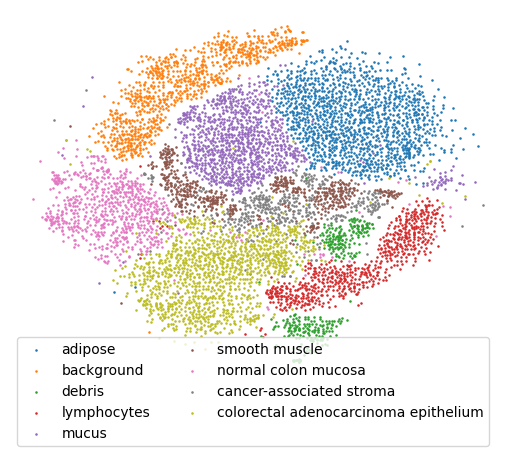

In [21]:
import matplotlib.pyplot as plt
from cuml.manifold import TSNE as cumlTSNE
# param for moco
# tsne = cumlTSNE(n_components=2, perplexity=10, learning_rate_method='auto', init='random', n_neighbors=30, n_iter=1000)
# param for supervised
tsne = cumlTSNE(n_components=2, perplexity=10, learning_rate_method='auto', init='random', n_neighbors=30, n_iter=1000)
z_embedded = tsne.fit_transform(embedding)

# z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embedding)

names = ['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium']
cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(0, y.max()+1):
  fst = z_embedded[(label.cpu() == i).squeeze(), 0]
  snd = z_embedded[(label.cpu() == i).squeeze(), 1]
  plt.scatter(fst.get(), snd.get(), c=cs[i], s=0.7, label=names[i])
plt.axis('off')
plt.legend(loc="lower left", bbox_to_anchor=(0, -0.2), ncol=2)


# PCA

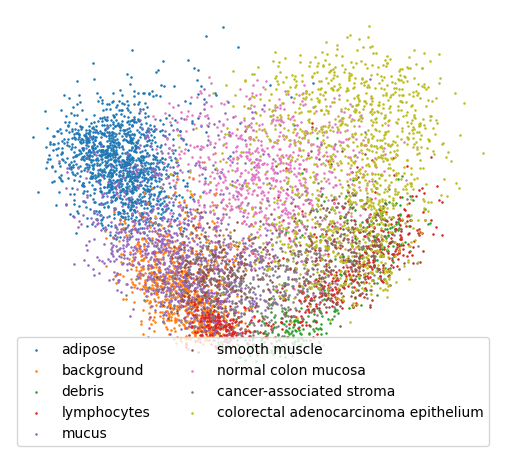

In [22]:
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
pca.fit(embedding.cpu())
z_embedded = pca.transform(embedding.cpu())

names = ['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium']
cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(0, y.max()+1):
  fst = z_embedded[(label.cpu() == i).squeeze(), 0]
  snd = z_embedded[(label.cpu() == i).squeeze(), 1]
  plt.scatter(fst, snd, c=cs[i], s=0.7, label=names[i])
plt.axis('off')
plt.legend(loc="lower left", bbox_to_anchor=(0, -0.2), ncol=2)

